# Unveiling Network Threats: Anomaly Detection in Intrusion Detection Systems 

In [1]:
%matplotlib inline
import requests
import numpy as np
import polars as pl
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.autolayout'] = True
plt.rcParams.update({'font.size': 18})

In [2]:
#df = pl.read_csv('https://cloud.hrun.duckdns.org/s/ZbwzSwEPk6pEds2/download/user-asn-sorted.csv', null_values=['-'])
df = pl.read_csv('user-asn-sorted.csv', null_values=['-'])
df = df.with_columns(pl.col('timestamp').str.to_datetime('%Y-%m-%dT%H:%M:%S'))
df.head()

shape: (5, 6)
┌─────────────────────┬──────────┬──────────┬───────┬──────────────┬───────────┐
│ timestamp           ┆ user     ┆ dst_port ┆ asn   ┆ malware_type ┆ signature │
│ ---                 ┆ ---      ┆ ---      ┆ ---   ┆ ---          ┆ ---       │
│ datetime[μs]        ┆ str      ┆ i64      ┆ i64   ┆ str          ┆ str       │
╞═════════════════════╪══════════╪══════════╪═══════╪══════════════╪═══════════╡
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null         ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null         ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null         ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null         ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 54113 ┆ null         ┆ null      │
└─────────────────────┴──────────┴──────────┴───────┴──────────────┴───────────┘

In [3]:
df.select(pl.all().is_null().sum())

shape: (1, 6)
┌───────────┬──────┬──────────┬─────┬──────────────┬───────────┐
│ timestamp ┆ user ┆ dst_port ┆ asn ┆ malware_type ┆ signature │
│ ---       ┆ ---  ┆ ---      ┆ --- ┆ ---          ┆ ---       │
│ u32       ┆ u32  ┆ u32      ┆ u32 ┆ u32          ┆ u32       │
╞═══════════╪══════╪══════════╪═════╪══════════════╪═══════════╡
│ 0         ┆ 0    ┆ 125871   ┆ 0   ┆ 4713105      ┆ 4711603   │
└───────────┴──────┴──────────┴─────┴──────────────┴───────────┘

In [4]:
df = df.drop('malware_type')
df.head()

shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬───────┬───────────┐
│ timestamp           ┆ user     ┆ dst_port ┆ asn   ┆ signature │
│ ---                 ┆ ---      ┆ ---      ┆ ---   ┆ ---       │
│ datetime[μs]        ┆ str      ┆ i64      ┆ i64   ┆ str       │
╞═════════════════════╪══════════╪══════════╪═══════╪═══════════╡
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ null      │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 54113 ┆ null      │
└─────────────────────┴──────────┴──────────┴───────┴───────────┘

In [5]:
signatures = df[['signature']].unique()['signature'].to_list()
dict_anomalies = {}
for k in signatures:
    if k is not None:
        dict_anomalies[k] = 1

df = df.with_columns(pl.col('signature').map_dict(dict_anomalies, default=0).alias('anomaly'))
df = df.drop('signature')

In [6]:
df.head()

shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬───────┬─────────┐
│ timestamp           ┆ user     ┆ dst_port ┆ asn   ┆ anomaly │
│ ---                 ┆ ---      ┆ ---      ┆ ---   ┆ ---     │
│ datetime[μs]        ┆ str      ┆ i64      ┆ i64   ┆ i64     │
╞═════════════════════╪══════════╪══════════╪═══════╪═════════╡
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 54113 ┆ 0       │
└─────────────────────┴──────────┴──────────┴───────┴─────────┘

In [7]:
r = requests.get('https://iptoasn.com/data/ip2asn-v4-u32.tsv.gz', headers={'User-agent': 'Mozilla/5.0'})
ASNs = pl.read_csv(r.content, separator='\t', has_header=False, new_columns=['start.ip','stop.ip','asn','country.code2','entity'])
ASNs = ASNs.filter(pl.col('asn') != 0)
ASNs.head()

shape: (5, 5)
┌──────────┬──────────┬────────┬───────────────┬───────────────────────────────────┐
│ start.ip ┆ stop.ip  ┆ asn    ┆ country.code2 ┆ entity                            │
│ ---      ┆ ---      ┆ ---    ┆ ---           ┆ ---                               │
│ i64      ┆ i64      ┆ i64    ┆ str           ┆ str                               │
╞══════════╪══════════╪════════╪═══════════════╪═══════════════════════════════════╡
│ 16777216 ┆ 16777471 ┆ 13335  ┆ US            ┆ CLOUDFLARENET                     │
│ 16778240 ┆ 16778751 ┆ 38803  ┆ AU            ┆ WPL-AS-AP Wirefreebroadband Pty … │
│ 16778752 ┆ 16779263 ┆ 38803  ┆ AU            ┆ WPL-AS-AP Wirefreebroadband Pty … │
│ 16781312 ┆ 16781567 ┆ 2519   ┆ JP            ┆ VECTANT ARTERIA Networks Corpora… │
│ 16785408 ┆ 16785663 ┆ 141748 ┆ PH            ┆ QDCI-AS-AP QUANTUM DATA COMMUNIC… │
└──────────┴──────────┴────────┴───────────────┴───────────────────────────────────┘

In [8]:
ASNs = ASNs[['asn','country.code2','entity']].unique()
ASNs.head()

shape: (5, 3)
┌────────┬───────────────┬───────────────────────────────────┐
│ asn    ┆ country.code2 ┆ entity                            │
│ ---    ┆ ---           ┆ ---                               │
│ i64    ┆ str           ┆ str                               │
╞════════╪═══════════════╪═══════════════════════════════════╡
│ 23969  ┆ TH            ┆ TOT-NET TOT Public Company Limit… │
│ 131098 ┆ KR            ┆ BDNSKR-AS-KR Korea Internet Secu… │
│ 59125  ┆ JP            ┆ CYBERHOME FAMILY NET JAPAN INCOR… │
│ 64050  ┆ SG            ┆ BCPL-SG BGPNET Global ASN         │
│ 2514   ┆ JP            ┆ INFOSPHERE NTT PC Communications… │
└────────┴───────────────┴───────────────────────────────────┘

In [9]:
df = df.join(ASNs, on='asn')
df.head()

shape: (5, 7)
┌─────────────────────┬──────────┬──────────┬───────┬─────────┬───────────────┬──────────┐
│ timestamp           ┆ user     ┆ dst_port ┆ asn   ┆ anomaly ┆ country.code2 ┆ entity   │
│ ---                 ┆ ---      ┆ ---      ┆ ---   ┆ ---     ┆ ---           ┆ ---      │
│ datetime[μs]        ┆ str      ┆ i64      ┆ i64   ┆ i64     ┆ str           ┆ str      │
╞═════════════════════╪══════════╪══════════╪═══════╪═════════╪═══════════════╪══════════╡
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       ┆ US            ┆ EDGECAST │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       ┆ US            ┆ EDGECAST │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       ┆ US            ┆ EDGECAST │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ 0       ┆ US            ┆ EDGECAST │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 54113 ┆ 0       ┆ US            ┆ FASTLY   │
└─────────────────────┴──────────┴──────────┴───────┴─────────┴───────────────┴──────────┘

In [10]:
countries = pl.read_csv('https://cloud.hrun.duckdns.org/s/qDCMSH5HbHKGszE/download/countries_codes_and_coordinates.csv', null_values=['-'])
countries = countries.drop(['country.code3','country.code.num'])
countries.head()

shape: (5, 4)
┌────────────────┬───────────────┬──────────┬────────┐
│ country        ┆ country.code2 ┆ lat      ┆ lon    │
│ ---            ┆ ---           ┆ ---      ┆ ---    │
│ str            ┆ str           ┆ f64      ┆ f64    │
╞════════════════╪═══════════════╪══════════╪════════╡
│ Afghanistan    ┆ AF            ┆ 33.0     ┆ 65.0   │
│ Albania        ┆ AL            ┆ 41.0     ┆ 20.0   │
│ Algeria        ┆ DZ            ┆ 28.0     ┆ 3.0    │
│ American Samoa ┆ AS            ┆ -14.3333 ┆ -170.0 │
│ Andorra        ┆ AD            ┆ 42.5     ┆ 1.6    │
└────────────────┴───────────────┴──────────┴────────┘

In [11]:
df = df.join(countries, on='country.code2')
df = df.rename({'country.code2': 'country_code'})
df.head()

shape: (5, 10)
┌─────────────────────┬──────────┬──────────┬───────┬───┬──────────┬───────────────┬──────┬───────┐
│ timestamp           ┆ user     ┆ dst_port ┆ asn   ┆ … ┆ entity   ┆ country       ┆ lat  ┆ lon   │
│ ---                 ┆ ---      ┆ ---      ┆ ---   ┆   ┆ ---      ┆ ---           ┆ ---  ┆ ---   │
│ datetime[μs]        ┆ str      ┆ i64      ┆ i64   ┆   ┆ str      ┆ str           ┆ f64  ┆ f64   │
╞═════════════════════╪══════════╪══════════╪═══════╪═══╪══════════╪═══════════════╪══════╪═══════╡
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ … ┆ EDGECAST ┆ United States ┆ 38.0 ┆ -97.0 │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ … ┆ EDGECAST ┆ United States ┆ 38.0 ┆ -97.0 │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ … ┆ EDGECAST ┆ United States ┆ 38.0 ┆ -97.0 │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 15133 ┆ … ┆ EDGECAST ┆ United States ┆ 38.0 ┆ -97.0 │
│ 2023-10-03 16:00:00 ┆ 0028e812 ┆ 443      ┆ 54113 ┆ … ┆ FASTLY   ┆ United States ┆ 38.0 ┆ -97.0 │
└─────────────────────┴──────────┴──────────┴───────┴───┴──────────┴───────────────┴──────┴───────┘

In [12]:
single_user = df.filter(pl.col('user') == '0028e812')
connections = single_user.rows(named=True)

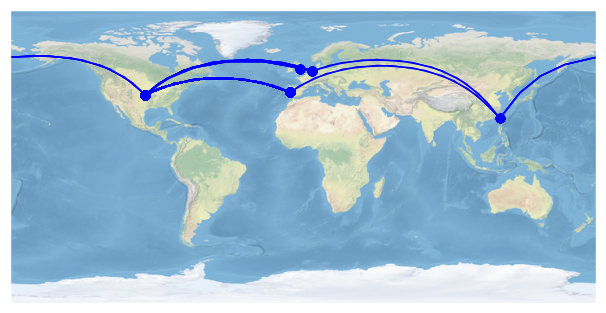

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for i in range(len(connections)-1):
    start = connections[i]
    stop = connections[i+1]
    plt.plot([start['lon'], stop['lon']], [start['lat'], 
    stop['lat']], color='blue', linewidth=1, marker='o', 
    transform=ccrs.Geodetic())

plt.show()

## Simple Classifier

In [14]:
df_clean = df[['user', 'dst_port', 'asn', 'entity', 'country_code', 'anomaly']]
df_clean.head()

shape: (5, 6)
┌──────────┬──────────┬───────┬──────────┬──────────────┬─────────┐
│ user     ┆ dst_port ┆ asn   ┆ entity   ┆ country_code ┆ anomaly │
│ ---      ┆ ---      ┆ ---   ┆ ---      ┆ ---          ┆ ---     │
│ str      ┆ i64      ┆ i64   ┆ str      ┆ str          ┆ i64     │
╞══════════╪══════════╪═══════╪══════════╪══════════════╪═════════╡
│ 0028e812 ┆ 443      ┆ 15133 ┆ EDGECAST ┆ US           ┆ 0       │
│ 0028e812 ┆ 443      ┆ 15133 ┆ EDGECAST ┆ US           ┆ 0       │
│ 0028e812 ┆ 443      ┆ 15133 ┆ EDGECAST ┆ US           ┆ 0       │
│ 0028e812 ┆ 443      ┆ 15133 ┆ EDGECAST ┆ US           ┆ 0       │
│ 0028e812 ┆ 443      ┆ 54113 ┆ FASTLY   ┆ US           ┆ 0       │
└──────────┴──────────┴───────┴──────────┴──────────────┴─────────┘

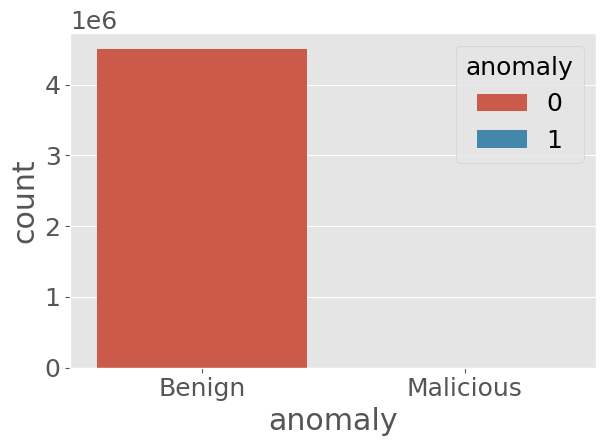

In [15]:
ax=sns.countplot(df_clean, x='anomaly',hue='anomaly')
ax.set_xticks([0,1])
ax.set_xticklabels(['Benign', 'Malicious'])
plt.show()

In [16]:
df_malicious = df_clean.filter(pl.col('anomaly') == 1)
df_benign    = df_clean.filter(pl.col('anomaly') == 0)

df_benign_downsample = resample(df_benign, replace=True, 
n_samples=len(df_malicious), random_state=42)

df_downsampled = pl.concat([df_malicious, df_benign_downsample])

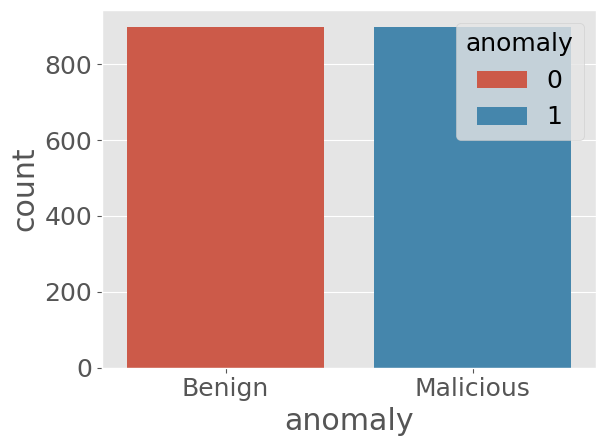

In [17]:
ax=sns.countplot(df_downsampled, x='anomaly',hue='anomaly')
ax.set_xticks([0,1])
ax.set_xticklabels(['Benign', 'Malicious'])
plt.show()

In [18]:
Y = df_downsampled['anomaly']
X = df_downsampled.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

enc = OneHotEncoder(max_categories=5, sparse_output=False, handle_unknown='ignore')
X_train = enc.fit_transform(X_train)
X_test  = enc.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [19]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

              precision    recall  f1-score   support

      Benign       0.91      0.82      0.86       272
   Malicious       0.84      0.92      0.88       267

    accuracy                           0.87       539
   macro avg       0.87      0.87      0.87       539
weighted avg       0.87      0.87      0.87       539



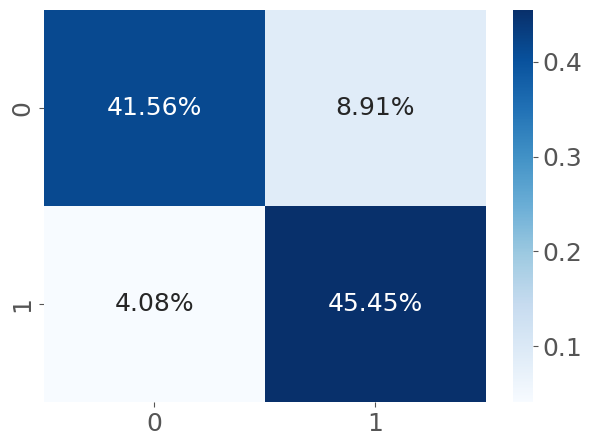

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

## Packet Flows

In [21]:
def dataframe_shift(df, columns, windows):

    for c in columns:
        for i in range(1, windows):
            df = df.with_columns((df[c].shift(i)).alias(f'prev_{c}_{i}'))

    return df.drop_nulls()

In [25]:
df_users = df_clean.partition_by(by='user', as_dict=True)

window = 3

for k in df_users:
    df_aux = df_users[k]
    df_users[k] = dataframe_shift(df_aux, columns=['dst_port', 'asn', 'entity', 'country_code'], windows=5)
    

In [26]:
df_users

{'0028e812': shape: (1_309, 22)
 ┌──────────┬──────────┬───────┬───────────┬───┬─────────────┬────────────┬────────────┬────────────┐
 │ user     ┆ dst_port ┆ asn   ┆ entity    ┆ … ┆ prev_countr ┆ prev_count ┆ prev_count ┆ prev_count │
 │ ---      ┆ ---      ┆ ---   ┆ ---       ┆   ┆ y_code_1    ┆ ry_code_2  ┆ ry_code_3  ┆ ry_code_4  │
 │ str      ┆ i64      ┆ i64   ┆ str       ┆   ┆ ---         ┆ ---        ┆ ---        ┆ ---        │
 │          ┆          ┆       ┆           ┆   ┆ str         ┆ str        ┆ str        ┆ str        │
 ╞══════════╪══════════╪═══════╪═══════════╪═══╪═════════════╪════════════╪════════════╪════════════╡
 │ 0028e812 ┆ 443      ┆ 54113 ┆ FASTLY    ┆ … ┆ US          ┆ US         ┆ US         ┆ US         │
 │ 0028e812 ┆ 443      ┆ 54113 ┆ FASTLY    ┆ … ┆ US          ┆ US         ┆ US         ┆ US         │
 │ 0028e812 ┆ 443      ┆ 54113 ┆ FASTLY    ┆ … ┆ US          ┆ US         ┆ US         ┆ US         │
 │ 0028e812 ┆ 443      ┆ 54113 ┆ FASTLY    ┆ … ┆ U